This one was tested on colab but produced a better image after normalizing the image using dataset means an writing out the equations.  Also using content image as starting point  improves things

In [0]:
%matplotlib inline

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
import socket, getpass
#import nntools as nt
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.keras.preprocessing import image as kp_image
from torch import optim
from torch.autograd import Variable

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#ls /content/gdrive/'Team Drive'/'Test_photos'

test/


# Data Loader:

In [0]:
inverse = tv.transforms.Compose([tv.transforms.Lambda(lambda x: x.mul_(1./255)),
                           tv.transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.225, 1/0.224, 1/0.229 ])   , 
                           tv.transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           #tv.transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                           #tv.transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])
                           tv.transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
toImage = tv.transforms.Compose([tv.transforms.ToPILImage()])


In [0]:
def myimshow(image, ax=plt):
    image = image.to('cpu').squeeze()
    image = inverse(image)
    #image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    #image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    image = toImage(image)
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [0]:
#style_train = pd.read_csv('/datasets/ee285f-public/wikiart/Style/style_train.csv', header=None)
#style_img = style_train[0].tolist() # list of jpg files of style images 
#style_type = style_train[1].tolist() # list of numbers

In [0]:
class WikiartDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(512, 512)):
        super(WikiartDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.images = style_img
        self.styles = style_type
        self.images_dir = os.path.join(root_dir)
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "WikiartDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.images[idx])
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        x = transform(img)
        d = self.styles[idx]
        return x, d
    def number_of_classes(self):
        return len(set(self.styles))

In [0]:
image_root_dir='/datasets/ee285f-public/wikiart/wikiart/'
#wikiart = WikiartDataset(image_root_dir)

In [0]:
#myimshow(wikiart[5][0]) # This image will be our content image in part 1

In [0]:
#myimshow(wikiart[114][0]) # This image will be our content image in part 1

# 1 Neural Style Transfer

# Feature Extraction

In [0]:
vgg = tv.models.vgg19(pretrained=True).eval().to(device)
features = vgg.features
for param in vgg.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:29<00:00, 19212901.56it/s]


In [0]:
def compute_mse(F,P):
    loss = nn.MSELoss()
    return loss(F, P)

In [0]:
#style_layers = [0,5,10,19,28] # works best.. 19 is batch, 21 is conv2d
#content_layer = 21

#style_layers = [1,6,11,20,29] # works worst
#content_layer = 22

style_layers = [2,7,12,21,30] # works alright
content_layer = 23

#style_layers = [0,7,14,27,40]
#content_layer = 27

optIm = torch.zeros(1,3, 512, 512).data.normal_(0, .5).view(3,512,512) # generated image

In [0]:
def compute_cont_loss(i,x,p):
    return (1/2) * (((vgg.features[:i](x.unsqueeze(0))-vgg.features[:i](p.unsqueeze(0)))**2).sum())
    #return compute_mse(vgg.features[:i](x.unsqueeze(0)),vgg.features[:i](p.unsqueeze(0)))

In [0]:
#Gram Matrix
def compute_style_loss(i,x,a):
    G = vgg.features[:i](x.unsqueeze(0))
    A = vgg.features[:i](a.unsqueeze(0))
    N = G.shape[1]
    M = G.shape[2]*G.shape[3]
    #style_activations[i] = style_activations[i].squeeze().view(style_activations[i].shape[1], -1).detach()
    # The multiplication inside G.view() and A.view() is simply reshaping G and A to do mm
    G = torch.mm(G.view(G.shape[0]*G.shape[1],G.shape[2]*G.shape[3]), 
                 G.view(G.shape[0]*G.shape[1],G.shape[2]*G.shape[3]).t())
    #print(G.shape)
    
    A = torch.mm(A.view(A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]), 
                 A.view(A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]).t())

    return  (1./(4 * N**2 * M**2)) * ((G-A)**2).sum()
    #return 1/(4*(N**2)*(M**2))*compute_mse(G,A)

In [0]:
def evaluate_loss(x,a,p):
    loss_cont = 1*compute_cont_loss(content_layer,x,p)
    E = []
    #style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    #style_weights = [10,1,.1,.1,.1]
    #style_weights = [.001,.05,.1,7,25]
    style_weights  =[1e4/n**2 for n in [1,1,1,1,1]]

    for i in range(len(style_layers)):    
        E.append(style_weights[i]*compute_style_loss(style_layers[i],x,a))
    loss = loss_cont +sum(E)/5
    return loss,loss_cont,sum(E)/5

In [0]:
def optimize(optIm,a,p,iterations=700):
    x = Variable(optIm.data.clone().to(device), requires_grad=True)
    
    optimizer = optim.LBFGS([x],max_iter=1);
    
    n_iter=[0]
    tot_loss_ar = []
    tot_loss_cont_ar = []
    tot_loss_style_ar = []
    fig = plt.figure(figsize=(8,8))

    while n_iter[0] <= iterations:
        if n_iter[0]%50 == 0:
            print(n_iter[0])
            ax1=plt.subplot(2, 2, 1)
            ax1.set_title('Style Image')
            myimshow(a)
            #plt.imshow(postp(a.data.cpu().squeeze()))
            #myimshow(a.data.cpu().squeeze())
            ax1=plt.subplot(2, 2, 2)
            ax1.set_title('Content Image')
            myimshow(p)
            #plt.imshow(postp(p.data.cpu().squeeze()))
            #myimshow(p.data.cpu().squeeze())
            ax1=plt.subplot(2, 2, 3)
            ax1.set_title('Output Image')
            myimshow(x.detach())
            #plt.imshow(postp(x.detach().data.cpu().squeeze()))
            #myimshow(x.detach().data.cpu().squeeze())
            ax1=plt.subplot(2, 2, 4)
            ax1.set_title('Losses')

            line_one, = plt.plot(np.log10(tot_loss_ar), label='Total Loss')
            line_two, = plt.plot(np.log10(tot_loss_cont_ar), label='Cont. Loss')
            line_three, = plt.plot(np.log10(tot_loss_style_ar), label='Style Loss')

            plt.legend(handles=[line_one, line_two, line_three])
            plt.ylabel('loss (log10)')
            plt.tight_layout()
            fig.canvas.draw()
            fig.savefig(str(n_iter[0])+'_test.jpg', bbox_inches='tight')
        def closure():
            optimizer.zero_grad()
            loss,loss_cont,E= evaluate_loss(x,a,p)
            tot_loss_ar.append(loss.detach())
            tot_loss_cont_ar.append(loss_cont.detach())
            tot_loss_style_ar.append(E.detach())


            loss.backward()
            n_iter[0]+=1

            return loss
        optimizer.step(closure)
    return x
    plt.close()

In [0]:
def getDataset(path,image_size=(512,512)):

    transform = tv.transforms.Compose([tv.transforms.Resize((512,512)),
                                       tv.transforms.ToTensor(),
                                       tv.transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                                       tv.transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #imagenet mean and std
                                                            std=[0.225,0.224,0.229]),
                                      # tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                       tv.transforms.Lambda(lambda x: x.mul_(255)),
                                      ])
    dataset = tv.datasets.ImageFolder(path,transform)
    return dataset

testImages = getDataset('gdrive/Team Drives/ECE 285/Test_photos')

In [0]:
from matplotlib import pyplot as plt

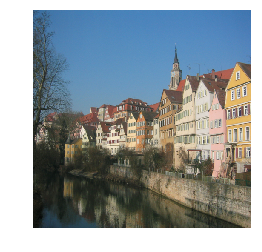

In [0]:
plt.figure()
#myimshow(testImages[0][0])
#plt.imshow(postp(testImages[0][0].data.cpu().squeeze())
myimshow(testImages[0][0].to(device))

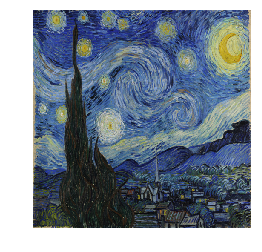

In [0]:
plt.figure()
myimshow(testImages[1][0].to(device))
plt.show()

0
50


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


100
150
200
250
300
350
400
450
500


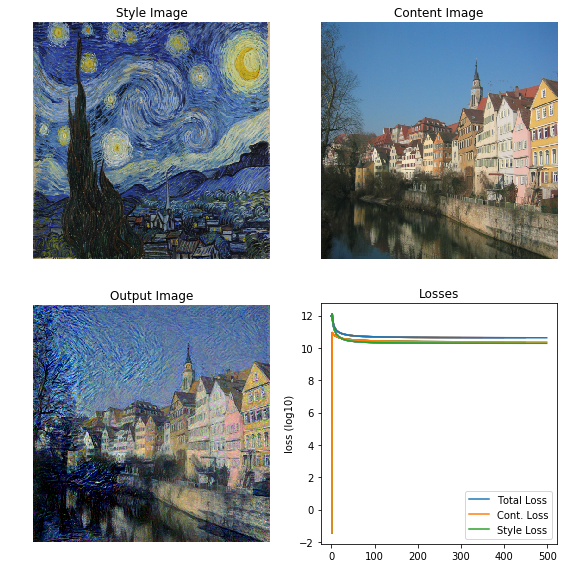

In [0]:
a = testImages[1][0].to(device)
p = testImages[0][0].to(device)
#optIm = torch.zeros(1,3, 512, 512).data.normal_(0, .5).view(3,512,512) # generated image
#optIm = torch.randn(p.size()).type_as(p.data)
#optIm = prep(optIm)
optIm = p #p as starting point
x = optimize(optIm,a,p,500)
#optImg.data[0].cpu()